# CS446/519 - Class Session 7 - Transitivity (Clustering Coefficients)

In this class session we are going to compute the local clustering coefficient of all vertices in the undirected human
protein-protein interaction network (PPI), in two ways -- first without using `igraph`, and the using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder), we'll make an "adjacency forest" representation of the network, and we'll manually compute the local clustering coefficient of each vertex (protein) in the network using the "enumerating neighbor pairs" method described by Newman. Then we'll run the same algorithm using the `transitivity_local_undirected` function in `igraph`, and we'll compare the results in order to check our work.  Grad students:  you should also group vertices by their "binned" vertex degree k (bin size 50, total number of bins = 25) and plot the average local clustering coefficient for the vertices within a bin, against the center k value for the bin, on log-log scale (compare to Newman Fig. 8.12)

In [3]:
from igraph import Graph
from igraph import summary
import pandas
import numpy
import timeit
from pympler import asizeof
import bintrees

Step 1:  load in the SIF file (refer to Class 6 exercise) into a data frame `sif_data`, using the `pandas.read_csv` function, and name the columns `species1`, `interaction_type`, and `species2`.

In [4]:
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                           sep="\t", names=["species1","interaction_type","species2"])

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with"), by using the `isin` function and then using `[` to index rows into the data frame.  Call the returned ata frame `interac_ppi`.

In [5]:
interaction_types_ppi = set(["interacts-with",
                             "in-complex-with"])
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)]

Step 3: restrict the data frame to only the unique interaction pairs of proteins (ignoring the interaction type), and call that data frame `interac_ppi_unique`. Make an igraph `Graph` object from `interac_ppi_unique` using `Graph.TupleList`, `values`, and `tolist`. Call `summary` on the `Graph` object. Refer to the notebooks for the in-class exercises in Class sessions 3 and 6.

In [6]:
for i in range(0, interac_ppi.shape[0]):
    if interac_ppi.iat[i,0] > interac_ppi.iat[i,2]:
        temp_name = interac_ppi.iat[i,0]
        interac_ppi.set_value(i, 'species1', interac_ppi.iat[i,2])
        interac_ppi.set_value(i, 'species2', temp_name)
        
interac_ppi_unique = interac_ppi[["species1","species2"]].drop_duplicates()        


ppi_igraph = Graph.TupleList(interac_ppi_unique.values.tolist(), directed=False)
summary(ppi_igraph)

IGRAPH UN-- 17531 475553 -- 
+ attr: name (v)


Step 4: Obtain an adjacency list representation of the graph (refer to Class 5 exercise), using `get_adjlist`.

In [7]:
ppi_adj_list = ppi_igraph.get_adjlist()

Step 5: Make an "adjacency forest" data structure as a list of `AVLTree` objects (refer to Class 5 exercise).  Call this adjacency forest, `ppi_adj_forest`.

In [8]:
def get_bst_forest(theadjlist):
    g_adj_list = theadjlist
    n = len(g_adj_list)
    theforest = []
    for i in range(0,n):        
        itree = bintrees.AVLTree()
        for j in g_adj_list[i]:
            itree.insert(j,1)
        theforest.append(itree)
    return theforest

def find_bst_forest(bst_forest, i, j):
    return j in bst_forest[i]

ppi_adj_forest = get_bst_forest(ppi_adj_list)

Step 6: Compute the local clustering coefficient (Ci) values of the first 100 vertices (do timing on this operation) as a `numpy.array`; for any vertex with degree=1, it's Ci value can be numpy `NaN`. You'll probably want to have an outer `for` loop for vertex ID `n` going from 0 to 99, and then an inner `for` loop iterating over neighbor vertices of vertex `n`. Store the clustering coefficients in a list, `civals`. Print out how many seconds it takes to perform this calculation.

In [ ]:
N = len(ppi_adj_list)
civals = numpy.zeros(100)
civals[:] = numpy.NaN
start_time = timeit.default_timer()

## PUT CODE HERE TO CALCULATE THE LOCAL CLUSTERING COEFFICIENT
        
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

Step 7: Calculate the local clustering coefficients for the first 100 vertices using 
the method `igraph.Graph.transitivity_local_undirected` and save the results as a list `civals_igraph`. Do timing on the call to `transitivity_local_undirected`, using `vertices=` to specify the vertices for which you want to compute the local clustering coefficient.

In [27]:
start_time = timeit.default_timer()
civals_igraph = ppi_igraph.transitivity_local_undirected(vertices=list(range(0,100)))
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

0.6943544051609933


Step 8: Compare your Ci values to those that you got from `igraph`, using a scatter plot where `civals` is on the horizontal axis and `civals_igraph` is on the vertical axis.

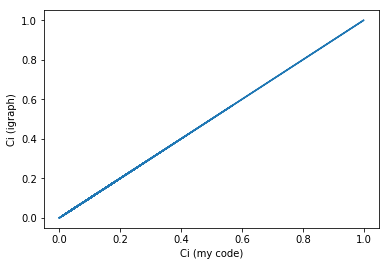

In [29]:
import matplotlib.pyplot
matplotlib.pyplot.plot(civals, civals_igraph)
matplotlib.pyplot.xlabel("Ci (my code)")
matplotlib.pyplot.ylabel("Ci (igraph)")
matplotlib.pyplot.show()

Step 9:  scatter plot the average log(Ci) vs. log(k) (i.e., local clustering coefficient vs. vertex degree) for 25 bins of vertex degree, with each bin size being 50 (so we are binning by k, and the bin centers are 50, 100, 150, 200, ...., 1250)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


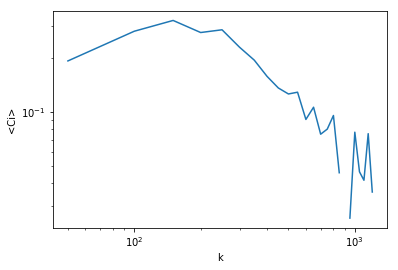

In [19]:
civals_igraph = numpy.array(ppi_igraph.transitivity_local_undirected())
deg_igraph = ppi_igraph.degree()
deg_npa = numpy.array(deg_igraph)
deg_binids = numpy.rint(deg_npa/50)
binkvals = 50*numpy.array(range(0,25))
civals_avg = numpy.zeros(25)
for i in range(0,25):
    civals_avg[i] = numpy.mean(civals_igraph[deg_binids == i])
 
matplotlib.pyplot.loglog(
     binkvals,
     civals_avg)
matplotlib.pyplot.ylabel("<Ci>")
matplotlib.pyplot.xlabel("k")
matplotlib.pyplot.show()

Step 10: Now try computing the local clustering coefficient using a "list of hashtables" approach; compute the local clustering coefficients for all vertices, and compare to the timing for R.  Which is faster, the python3 implementation or the R implementation?

In [30]:
civals = numpy.zeros(len(ppi_adj_list))
civals[:] = numpy.NaN

ppi_adj_hash = []
for i in range(0, len(ppi_adj_list)):
    newhash = {}
    for j in ppi_adj_list[i]:
        newhash[j] = True
    ppi_adj_hash.append(newhash)

    
start_time = timeit.default_timer()
for n in range(0, len(ppi_adj_list)):
    neighbors = ppi_adj_hash[n]
    nneighbors = len(neighbors)
    if nneighbors > 1:
        nctr = 0
        for i in neighbors:
            for j in neighbors:
                if (j > i) and (j in ppi_adj_hash[i]):
                    nctr += 1
        civals[n] = nctr/(nneighbors*(nneighbors-1)/2)
        
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

28.919685007072985


So the built-in python dictionary type gave us fantastic performance.  But is this coming at the cost of huge memory footprint? Let's check the size of our adjacency "list of hashtables", in MB:

In [47]:
asizeof.asizeof(ppi_adj_hash)/1000000

81.793984